In [1]:
!wget https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip

--2024-08-27 18:02:18--  https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bike+sharing+dataset.zip’

bike+sharing+datase     [   <=>              ] 273.43K   495KB/s    in 0.6s    

2024-08-27 18:02:20 (495 KB/s) - ‘bike+sharing+dataset.zip’ saved [279992]



In [2]:
!unzip bike+sharing+dataset.zip

Archive:  bike+sharing+dataset.zip
  inflating: Readme.txt              
  inflating: day.csv                 
  inflating: hour.csv                


In [3]:
import pandas as pd
df = pd.read_csv('hour.csv')
df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [4]:
df['day_night'] = df['hr'].apply(lambda x: 'day' if 6 <= x <= 18 else 'night')

In [5]:
df.drop(['instant', 'casual', 'registered'], axis=1, inplace=True)
df['dteday'] = pd.to_datetime(df.dteday)
df['season'] = df.season.astype('category')
df['holiday'] = df.holiday.astype('category')
df['weekday'] = df.weekday.astype('category')
df['weathersit'] = df.weathersit.astype('category')
df['workingday'] = df.workingday.astype('category')
df['mnth'] = df.mnth.astype('category')
df['yr'] = df.yr.astype('category')
df['hr'] = df.hr.astype('category')
df.drop(columns=['dteday'], inplace=True)
# Separating features and target variable
X = df.drop(columns=['cnt']) # Features
y = df['cnt'] # Target

In [6]:
# Using OneHotEncoder

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
# Numerical features
numerical_features = ['temp', 'hum', 'windspeed']
numerical_pipeline = Pipeline([
('imputer', SimpleImputer(strategy='mean')), # Impute missing values with mean
('scaler', MinMaxScaler()) # Normalize using MinMaxScaler
])
# Transforming above
X[numerical_features] = numerical_pipeline.fit_transform(X[numerical_features])
# Categorical features
categorical_features = ['season', 'weathersit', 'day_night']
categorical_pipeline = Pipeline([
('imputer', SimpleImputer(strategy='most_frequent')),
('onehot', OneHotEncoder(sparse_output=False, drop='first'))
])
# Transforming above
X_encoded = categorical_pipeline.fit_transform(X[categorical_features])
# Converting it to a dataframe
X_encoded = pd.DataFrame(X_encoded,
columns=categorical_pipeline.named_steps['onehot'].get_feature_names_out(categorical_features))
# Encoded categorical features + Numerical features
X = pd.concat([X.drop(columns=categorical_features), X_encoded], axis=1)


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)


In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

<Axes: >

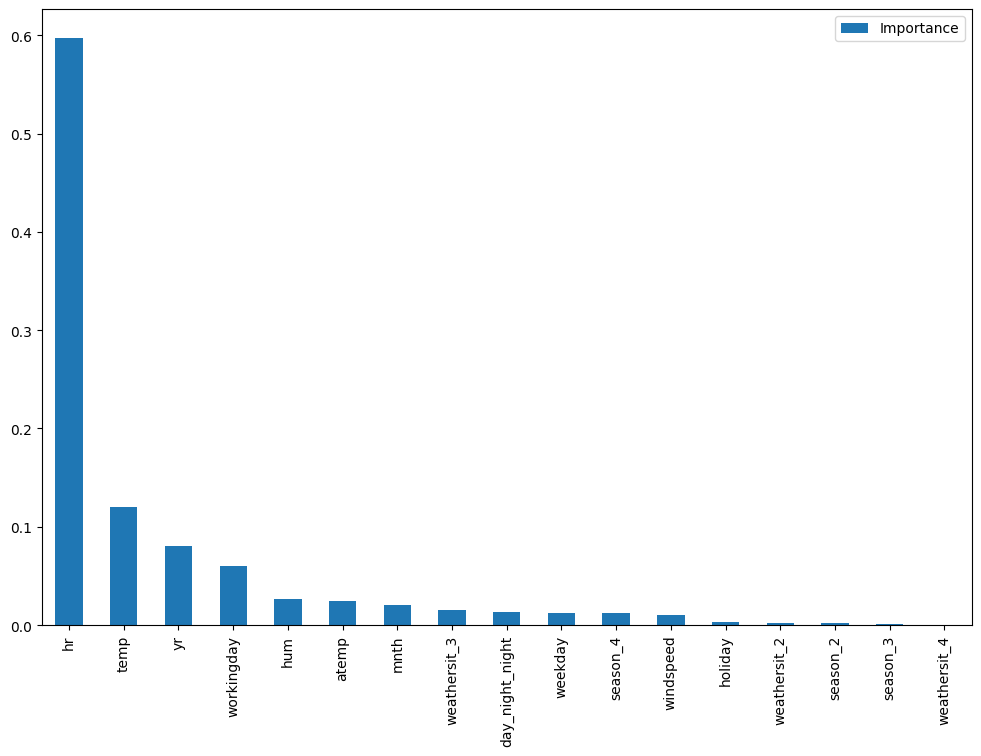

In [9]:
feat_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns,
columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
# Plotting each feature importance
feat_importances.plot(kind='bar', figsize=(12,8))

In [10]:
# Predictions
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Output of Random Forest Regressor using OneHotEncoder")
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Output of Random Forest Regressor using OneHotEncoder
Mean Squared Error: 1808.4074990292243
R-squared: 0.9428901308176855


In [11]:
final_pipeline = Pipeline([
('num_preprocess', numerical_pipeline),
('cat_preprocess', categorical_pipeline),
('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

from sklearn import set_config
set_config(display='diagram')# To display
final_pipeline

Pipeline(steps=[('num_preprocess',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('scaler', MinMaxScaler())])),
                ('cat_preprocess',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('onehot',
                                  OneHotEncoder(drop='first',
                                                sparse_output=False))])),
                ('model', RandomForestRegressor(random_state=42))])

MLops Assignment-2

Assignment: Enhancing and Optimizing an MLOps Pipeline
Objective:
The goal of this assignment is to extend the MLOps pipeline you’ve built during the lab sessions. You will explore strategies to enhance feature engineering, model selection, preprocessing techniques, and pipeline automation. The objective remains to predict the number of bike rentals (target variable: cnt) using the Bike Sharing dataset but with added complexity and optimization.

1. Create at least two new interaction features between numerical variables (e.g. temp * hum). Justify your choice of features and explain how they might improve the model's predictive performance

In [12]:
df = pd.read_csv('hour.csv')

In [13]:
# Creating a new filed which computes a numerical relationshi between Temperature and Humidity

df['temp_hum'] = df['temp'] * df['hum']

# Creating a second variable which is the product of windspeed and temperature

df['wind_temp'] = df['windspeed'] * df['atemp']

df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,temp_hum,wind_temp
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16,0.1944,0.000000
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40,0.1760,0.000000
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32,0.1760,0.000000
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13,0.1800,0.000000
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1,0.1800,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119,0.1560,0.042298
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89,0.1560,0.042298
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90,0.1560,0.042298
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61,0.1456,0.036624


In [14]:
df.drop(['instant', 'casual', 'registered'], axis=1, inplace=True)
df['dteday'] = pd.to_datetime(df.dteday)
df['season'] = df.season.astype('category')
df['holiday'] = df.holiday.astype('category')
df['weekday'] = df.weekday.astype('category')
df['weathersit'] = df.weathersit.astype('category')
df['workingday'] = df.workingday.astype('category')
df['mnth'] = df.mnth.astype('category')
df['yr'] = df.yr.astype('category')
df['hr'] = df.hr.astype('category')
df.drop(columns=['dteday'], inplace=True)
# Separating features and target variable
X = df.drop(columns=['cnt']) # Features
y = df['cnt'] # Target

Encoding and spilitting the new data with OneHotEncoder

In [15]:
# Using OneHotEncoder

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
# Numerical features
numerical_features = ['temp','atemp' , 'hum', 'windspeed','temp_hum', 'wind_temp']
numerical_pipeline = Pipeline([
('imputer', SimpleImputer(strategy='mean')), # Impute missing values with mean
('scaler', MinMaxScaler()) # Normalize using MinMaxScaler
])
# Transforming above
X[numerical_features] = numerical_pipeline.fit_transform(X[numerical_features])
# Categorical features
categorical_features = ['season', 'weathersit']
categorical_pipeline = Pipeline([
('imputer', SimpleImputer(strategy='most_frequent')),
('onehot', OneHotEncoder(sparse_output=False, drop='first'))
])
# Transforming above
X_encoded = categorical_pipeline.fit_transform(X[categorical_features])
# Converting it to a dataframe
X_encoded = pd.DataFrame(X_encoded,
columns=categorical_pipeline.named_steps['onehot'].get_feature_names_out(categorical_features))
# Encoded categorical features + Numerical features
X = pd.concat([X.drop(columns=categorical_features), X_encoded], axis=1)


In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
random_state=42)


Using Random forest on new data encoded using OneHotEncoder

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

<Axes: >

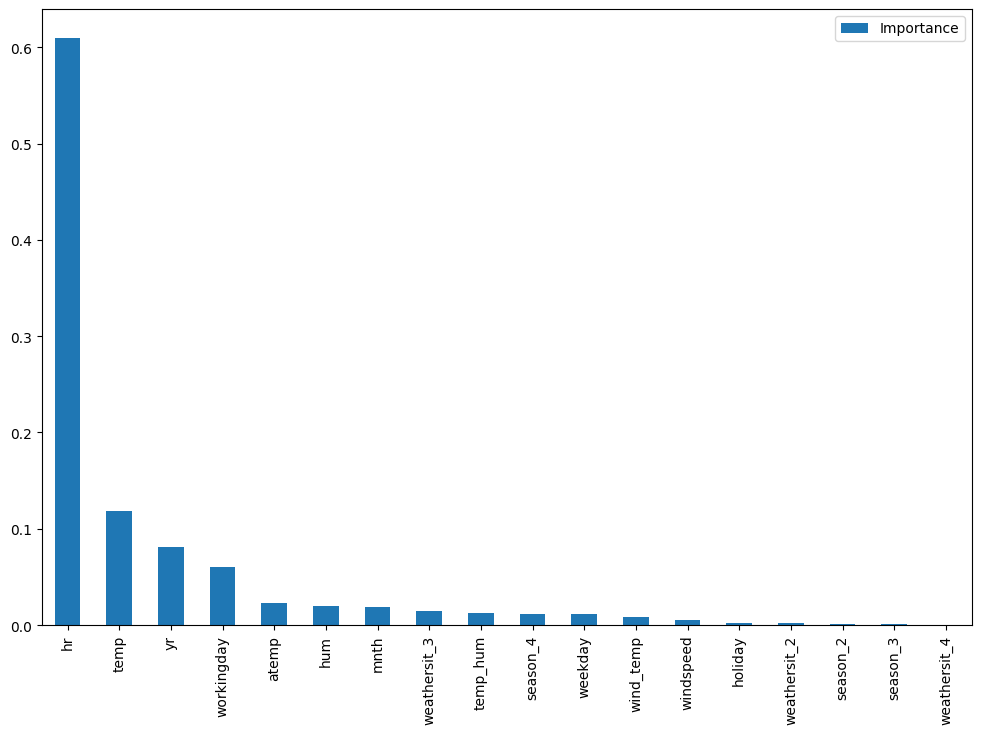

In [18]:
feat_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns,
columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
# Plotting each feature importance
feat_importances.plot(kind='bar', figsize=(12,8))

In [19]:
# Predictions
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Output of Random Forest Regressor using OneHotEncoder")
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Output of Random Forest Regressor using OneHotEncoder
Mean Squared Error: 1843.5181936270158
R-squared: 0.9417813280857478


In [20]:
final_pipeline = Pipeline([
('num_preprocess', numerical_pipeline),
('cat_preprocess', categorical_pipeline),
('model', RandomForestRegressor(n_estimators=100, random_state=42))
])
set_config(display='diagram')# To display
final_pipeline

Pipeline(steps=[('num_preprocess',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('scaler', MinMaxScaler())])),
                ('cat_preprocess',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('onehot',
                                  OneHotEncoder(drop='first',
                                                sparse_output=False))])),
                ('model', RandomForestRegressor(random_state=42))])

Training using Linear Regression on the data encoded using OneHotEncoder

In [21]:
# Using the Linear Regression Package

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Output of Linear Regression using OneHotEncoder")
print(f'Linear Regression - Mean Squared Error: {mse_lr}')
print(f'Linear Regression - R-squared: {r2_lr}')

Output of Linear Regression using OneHotEncoder
Linear Regression - Mean Squared Error: 18755.230065536085
Linear Regression - R-squared: 0.40770609715898465


<Axes: >

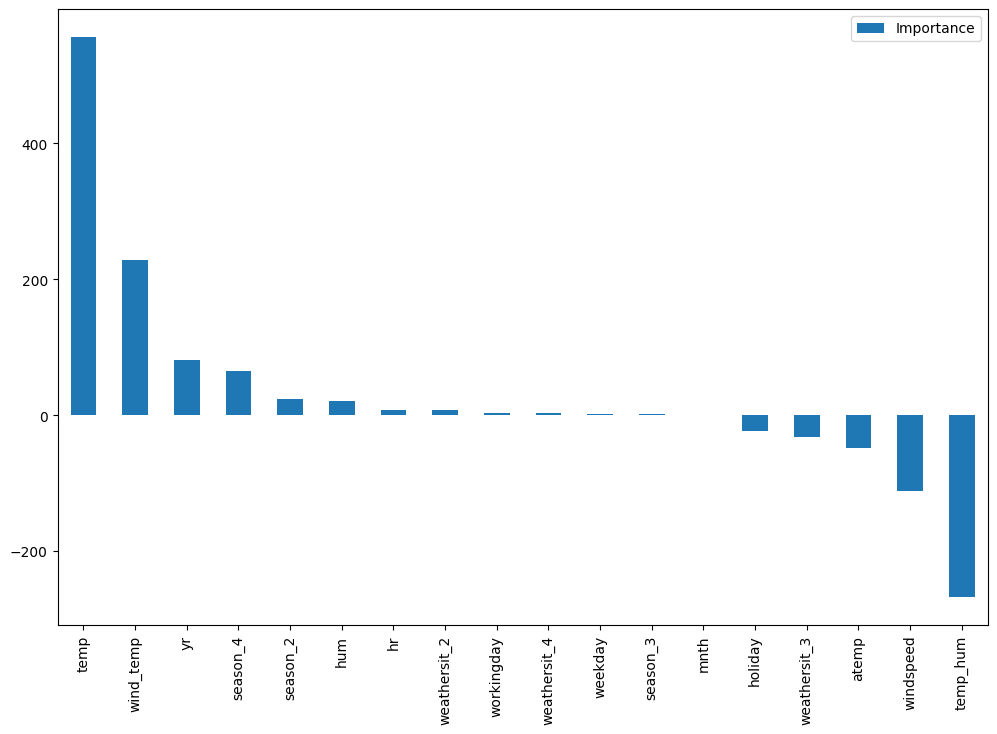

In [22]:
feat_importances = pd.DataFrame(model_lr.coef_, index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
# Plotting each feature importance
feat_importances.plot(kind='bar', figsize=(12,8))

In [23]:
final_pipeline = Pipeline([
('num_preprocess', numerical_pipeline),
('cat_preprocess', categorical_pipeline),
('model', LinearRegression())
])
set_config(display='diagram')# To display
final_pipeline



Pipeline(steps=[('num_preprocess',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('scaler', MinMaxScaler())])),
                ('cat_preprocess',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('onehot',
                                  OneHotEncoder(drop='first',
                                                sparse_output=False))])),
                ('model', LinearRegression())])

Training using Linear Regression built from scratch

In [24]:
# Creating Linear Regression from Scratch
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

class LinearRegressionScratch:
    def __init__(self):
        self.weights = None
        self.bias = None
        self.coef_ = None

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        # Adding a column of ones for the bias term
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        # Calculating weights using the normal equation
        self.weights = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
        self.bias = self.weights[0]  # First element is the bias (intercept)
        self.coef_ = self.weights[1:]  # Remaining elements are the feature coefficients

    def predict(self, X):
        X = np.array(X)
        return X.dot(self.coef_) + self.bias

    def get_feature_importances(self):
        # Returns the coefficients as a measure of feature importance.
        return self.coef_

# Initialize and train the scratch model
model_scratch = LinearRegressionScratch()
model_scratch.fit(X_train, y_train)

# Make predictions
y_pred_scratch = model_scratch.predict(X_test)

# Evaluate the model
mse_scratch = mean_squared_error(y_test, y_pred_scratch)
r2_scratch = r2_score(y_test, y_pred_scratch)

print("Output of Scratch Linear Regression using OneHotEncoder")
print(f'Scratch Linear Regression - Mean Squared Error: {mse_scratch}')
print(f'Scratch Linear Regression - R-squared: {r2_scratch}')


Output of Scratch Linear Regression using OneHotEncoder
Scratch Linear Regression - Mean Squared Error: 18755.23006553598
Scratch Linear Regression - R-squared: 0.407706097158988


<Axes: >

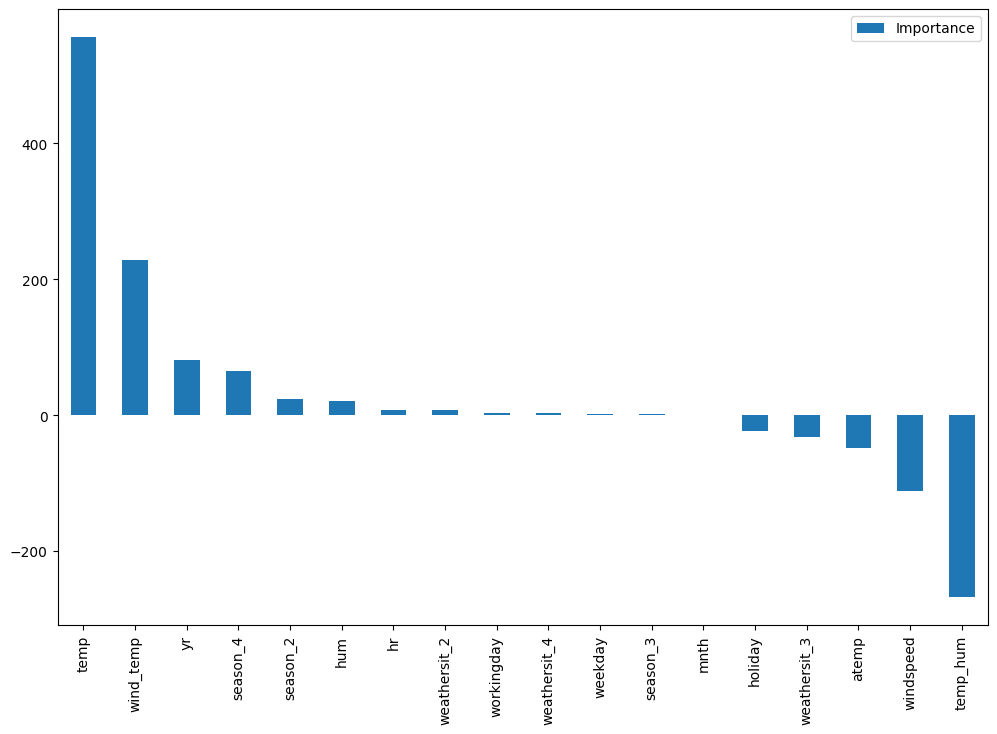

In [25]:
# Feature importances
feat_importances = pd.DataFrame(model_scratch.get_feature_importances(), index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plotting feature importances
feat_importances.plot(kind='bar', figsize=(12, 8))

In [26]:
final_pipeline = Pipeline([
('num_preprocess', numerical_pipeline),
('cat_preprocess', categorical_pipeline),
('model', LinearRegressionScratch())
])
set_config(display='diagram')# To display
final_pipeline


Pipeline(steps=[('num_preprocess',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('scaler', MinMaxScaler())])),
                ('cat_preprocess',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('onehot',
                                  OneHotEncoder(drop='first',
                                                sparse_output=False))])),
                ('model',
                 <__main__.LinearRegressionScratch object at 0x7f74ef64ae60>)])

In [27]:
# Reloading the dataset

df = pd.read_csv('hour.csv')

In [28]:
# Creating a new filed which takes if it is a working day and within working hours for rental car analysis

df['temp_hum'] = df['temp'] * df['hum']

# Creating a second filed which checks if the day is holyday and the weather is clean

df['wind_temp'] = df['windspeed'] * df['temp']

In [29]:
df.drop(['instant', 'casual', 'registered'], axis=1, inplace=True)
df['dteday'] = pd.to_datetime(df.dteday)
df['season'] = df.season.astype('category')
df['holiday'] = df.holiday.astype('category')
df['weekday'] = df.weekday.astype('category')
df['weathersit'] = df.weathersit.astype('category')
df['workingday'] = df.workingday.astype('category')
df['mnth'] = df.mnth.astype('category')
df['yr'] = df.yr.astype('category')
df['hr'] = df.hr.astype('category')
# df['temp_hum'] = df.temp_hum.astype('category')
# df['wind_temp'] = df.wind_temp.astype('category')
df.drop(columns=['dteday'], inplace=True)
# Separating features and target variable
X = df.drop(columns=['cnt']) # Features
y = df['cnt'] # Target


In [30]:
!pip install category_encoders
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.0 MB/s eta 0:00:00


Encoding data using Target Encoder

In [31]:
# Numerical features
numerical_features = ['temp','atemp' , 'hum', 'windspeed','temp_hum', 'wind_temp']
numerical_pipeline = Pipeline([
('imputer', SimpleImputer(strategy='mean')), # Impute missing values with mean
('scaler', MinMaxScaler()) # Normalize using MinMaxScaler
])
# Transforming above
X[numerical_features] = numerical_pipeline.fit_transform(X[numerical_features])
# Categorical features
categorical_features = ['season', 'weathersit']
categorical_pipeline = Pipeline([
('imputer', SimpleImputer(strategy='most_frequent')),
('target_encoder', TargetEncoder())
])
# Transforming above
X_encoded = categorical_pipeline.fit_transform(X[categorical_features], y)
# Converting it to a dataframe
X_encoded = pd.DataFrame(X_encoded,
columns=categorical_pipeline.named_steps['target_encoder'].get_feature_names_out(categorical_features))
# Encoded categorical features + Numerical features

X = pd.concat([X.drop(columns=categorical_features), X_encoded], axis=1)
X.columns = X.columns.astype(str)

In [32]:
X.isnull().sum()
X

,yr,mnth,hr,holiday,weekday,workingday,temp,atemp,hum,windspeed,temp_hum,wind_temp,0,1
0,0,1,0,0,6,0,0.224490,0.2879,0.81,0.000000,0.312039,0.000000,111.114569,204.869272
1,0,1,1,0,6,0,0.204082,0.2727,0.80,0.000000,0.282504,0.000000,111.114569,204.869272
2,0,1,2,0,6,0,0.204082,0.2727,0.80,0.000000,0.282504,0.000000,111.114569,204.869272
3,0,1,3,0,6,0,0.224490,0.2879,0.75,0.000000,0.288925,0.000000,111.114569,204.869272
4,0,1,4,0,6,0,0.224490,0.2879,0.75,0.000000,0.288925,0.000000,111.114569,204.869272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,12,19,0,1,1,0.244898,0.2576,0.60,0.193018,0.250401,0.062731,111.114569,175.165493
17375,1,12,20,0,1,1,0.244898,0.2576,0.60,0.193018,0.250401,0.062731,111.114569,175.165493
17376,1,12,21,0,1,1,0.244898,0.2576,0.60,0.193018,0.250401,0.062731,111.114569,204.869272
17377,1,12,22,0,1,1,0.244898,0.2727,0.56,0.157870,0.233708,0.051308,111.114569,204.869272


In [33]:
# Model split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
random_state=42)


In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

<Axes: >

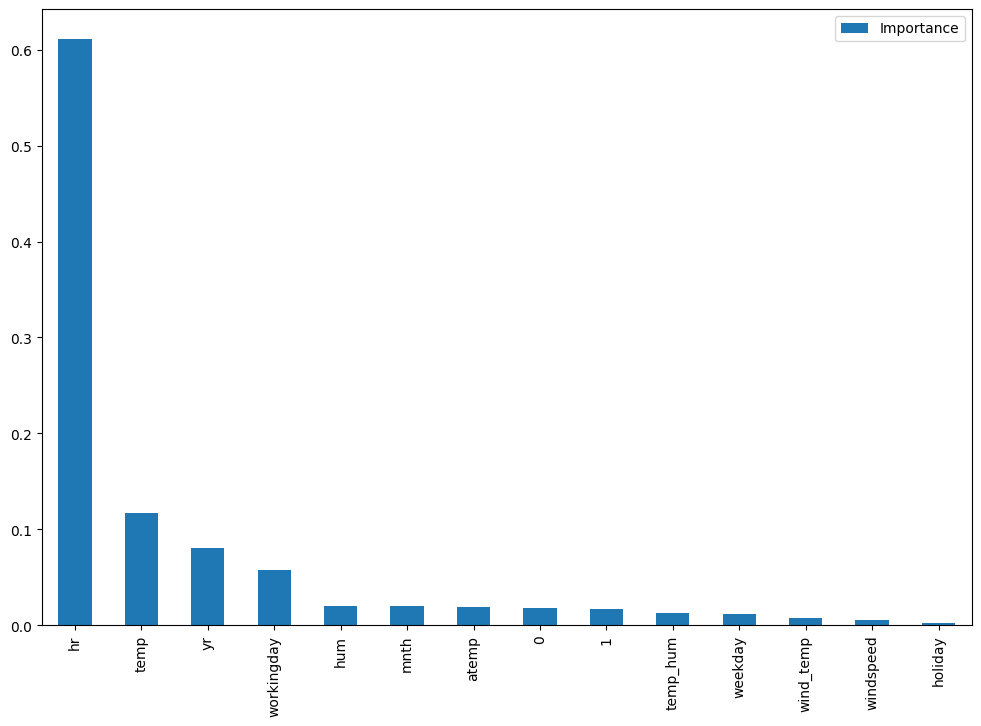

In [35]:
feat_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns,
columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
# Plotting each feature importance
feat_importances.plot(kind='bar', figsize=(12,8))

In [36]:
# Predictions
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Output of Random Forest Regressor using TargetEncoder")
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Output of Random Forest Regressor using TargetEncoder
Mean Squared Error: 1785.3000294504798
R-squared: 0.9436198693116282


In [37]:
final_pipeline = Pipeline([
('num_preprocess', numerical_pipeline),
('cat_preprocess', categorical_pipeline),
('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

from sklearn import set_config
set_config(display='diagram')# To display
final_pipeline

Pipeline(steps=[('num_preprocess',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('scaler', MinMaxScaler())])),
                ('cat_preprocess',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('target_encoder',
                                  TargetEncoder(cols=[0, 1]))])),
                ('model', RandomForestRegressor(random_state=42))])

In [38]:
# Using the Linear Regression Package

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Output of Linear Regression using TargetEncoder")
print(f'Linear Regression - Mean Squared Error: {mse_lr}')
print(f'Linear Regression - R-squared: {r2_lr}')

Output of Linear Regression using TargetEncoder
Linear Regression - Mean Squared Error: 19139.70080092009
Linear Regression - R-squared: 0.3955644347217322


<Axes: >

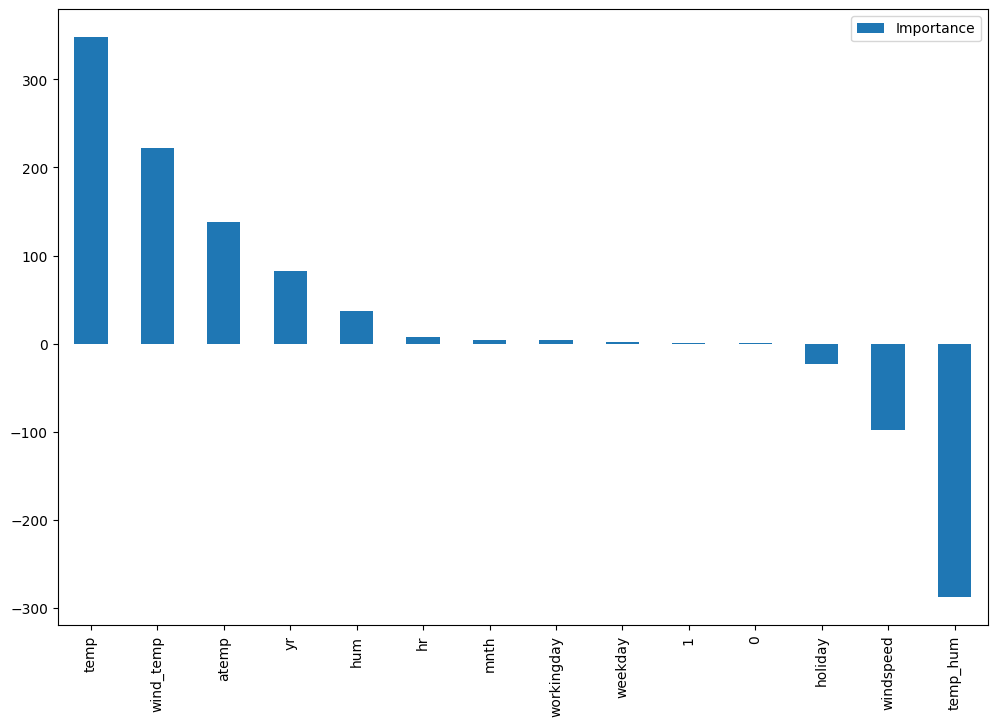

In [39]:
feat_importances = pd.DataFrame(model_lr.coef_, index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
# Plotting each feature importance
feat_importances.plot(kind='bar', figsize=(12,8))

In [40]:
final_pipeline = Pipeline([
('num_preprocess', numerical_pipeline),
('cat_preprocess', categorical_pipeline),
('model', LinearRegression())
])
set_config(display='diagram')# To display
final_pipeline

Pipeline(steps=[('num_preprocess',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('scaler', MinMaxScaler())])),
                ('cat_preprocess',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('target_encoder',
                                  TargetEncoder(cols=[0, 1]))])),
                ('model', LinearRegression())])

In [41]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

class LinearRegressionScratch:
    def __init__(self):
        self.weights = None
        self.bias = None
        self.coef_ = None

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        # Adding a column of ones for the bias term
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        # Calculating weights using the normal equation
        self.weights = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
        self.bias = self.weights[0]  # First element is the bias (intercept)
        self.coef_ = self.weights[1:]  # Remaining elements are the feature coefficients

    def predict(self, X):
        X = np.array(X)
        return X.dot(self.coef_) + self.bias

    def get_feature_importances(self):
        # Returns the coefficients as a measure of feature importance.
        return self.coef_

# Initialize and train the scratch model
model_scratch = LinearRegressionScratch()
model_scratch.fit(X_train, y_train)

# Make predictions
y_pred_scratch = model_scratch.predict(X_test)

# Evaluate the model
mse_scratch = mean_squared_error(y_test, y_pred_scratch)
r2_scratch = r2_score(y_test, y_pred_scratch)

print("Output of Scratch Linear Regression using TargetEncoder")
print(f'Scratch Linear Regression - Mean Squared Error: {mse_scratch}')
print(f'Scratch Linear Regression - R-squared: {r2_scratch}')

Output of Scratch Linear Regression using TargetEncoder
Scratch Linear Regression - Mean Squared Error: 19139.700800919163
Scratch Linear Regression - R-squared: 0.3955644347217614


<Axes: >

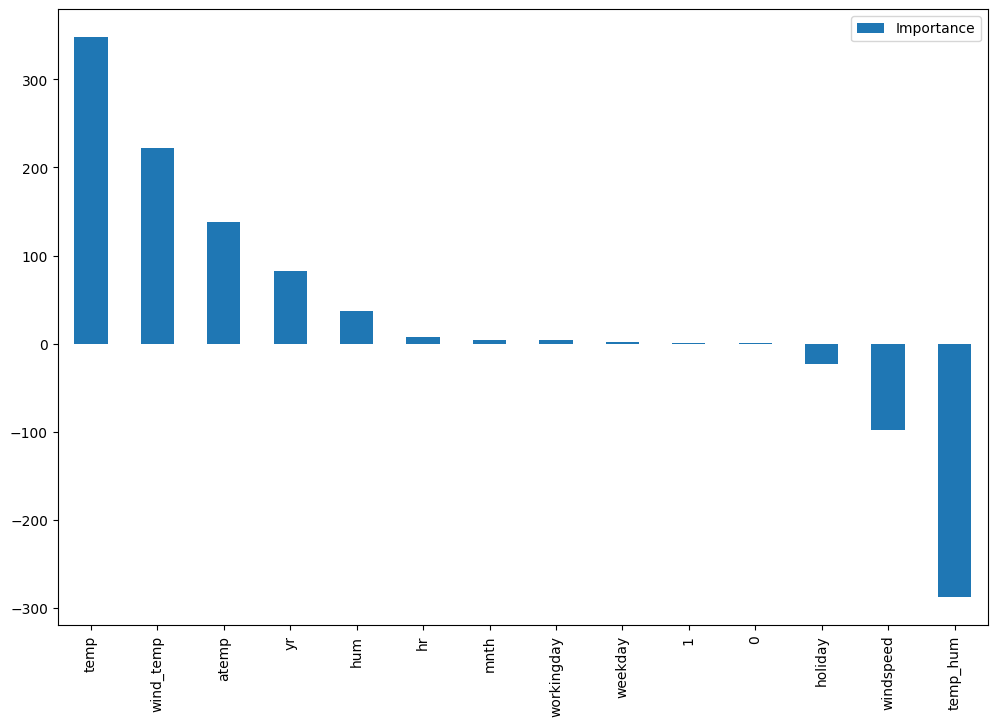

In [42]:
# Feature importances
feat_importances = pd.DataFrame(model_scratch.get_feature_importances(), index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plotting feature importances
feat_importances.plot(kind='bar', figsize=(12, 8))

In [43]:
final_pipeline = Pipeline([
('num_preprocess', numerical_pipeline),
('cat_preprocess', categorical_pipeline),
('model', LinearRegressionScratch())
])
set_config(display='diagram')# To display
final_pipeline

Pipeline(steps=[('num_preprocess',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('scaler', MinMaxScaler())])),
                ('cat_preprocess',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('target_encoder',
                                  TargetEncoder(cols=[0, 1]))])),
                ('model',
                 <__main__.LinearRegressionScratch object at 0x7f74dcde72b0>)])